# Example notebook for Proteus operations

### Author

Boris Nedyalkov, Quantum Computing Lab, IFAE, Barcelona

#### **In this notebook you will learn how to:**

* Import all the libraries one needs
* Set the working parameters of the machine
* Initialize the machine
* Create waveforms
* Download the waveforms to the Proteus
* Create a tasktable (sequences of pulses)
* Readout the signal [==UNDER DEVELOPEMENT==]
* Process the signal readout data [==UNDER DEVELOPEMENT==]

### Import some generic libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import os

srcpath = os.path.realpath('../../SourceFiles')
sys.path.append(srcpath)

# These are the Tabor developers' libraries, they allow us to I/O interface with the Proteus
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst

### Import our homemade libraries

In [2]:
import initializers  # this library contains intialization functions for the Proteus 

import pulse_lib # this library contains all the types of pulses, one can add here a new type of pulse if needed
import tasks # this library contains all the types of basic tasks, new ones can be added if need arises
import readers # this library contains all the readout functions

import helpers # this library contains auxillary functions

### Set the parameters of the machine

In [3]:
SCLK = 9e9  ### sampling clock rate of the generator (AWG)
DUC_INTERP = 1  ### the DUC interpolator mode

### Initialize the machine

In [4]:
# get the DAC mode, range, Serial port #, the data type of the system (8 or 16bit), and the instrument handle
dac_mode, max_dac, sid, data_type, inst = initializers.connection_func() # Make sure the Model name is P9484M, that the name of our module


=========CONNECTING=========
process id 3768
Connected to: Tabor Electronics,P9484M,000000220642,1.223.0
Model: P9484M
===CONNECTION ESTABLISHED===

===SYSTEM'S INFORMATION===
DAC waveform format: 16 bits-per-point
Max DAC wave-point level: 65535
Half DAC wave-point level: 32767.0
Number of channels: 4
Max segment number: 65536
Available memory per DDR: 8,581,545,984 wave-bytes
==========READY============


### Initialize the channels

In [5]:
# initialize channel 1
channel_numb = 1
initializers.initialization_func(channel_numb, inst, SCLK)

# # initialize all the channels
# for i in range(0,4):  
#     channel_numb = i + 1
#     initializers.initialization_func(channel_numb, inst, SCLK) 


===INITIALIZATION OF CHANNEL 1===  -->  ===DONE===
ERRORS: 0, no error


### Define some pulse shapes

In [6]:
pulse = pulse_lib.Pulse(SCLK, DUC_INTERP, show_plot = True)

Defining the sinus and the blank signal. After that we convert them to 16bit numbers (the Proteus takes its input in that format)

Note: A !WARNING! message may come if the data chunk representing the form doesn't have the right length of bytes.
An automatic script to convert it to the closest right length will engage and fix this. The resulting length of the waveform in bytes will be given after.

original seglen: 90000.0

!WARNING! The segment of the defined signal (90000.0 points) does not comply with the format of the possible data chunk for a signal, which is ||| datalength = ( 64 * (32 + n)) |||, where         n is an integer.
-----------Will edit the signal automatically to suit the # of points-----------

formated seglen: 89984
The blank singnal is with time width: 2.2755555555555555e-07


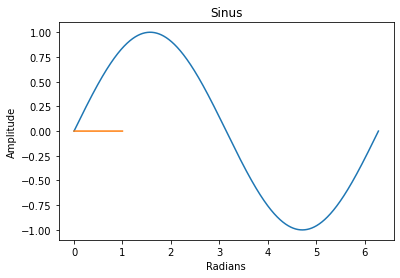

In [7]:
sin_f = pulse.simple_sin(amplitude = 1, frequency = 100000)  ### creating a sinus shape, frequency is in Hz

blank = pulse.blank_signal()

sin_f = helpers.digital_conv_func(sin_f, max_dac, data_type) ### converting the signal from float format array to a binary format array
blank = helpers.digital_conv_func(blank, max_dac, data_type)

@ Defining the parameters and creating a gaussian pulse. After that we convert the signal array to 16bit format (the Proteus takes its input in that format)

In [9]:
frequency = 1e6 ### frequency of the oscillation
sigma = 340e-08  ### make it bigger then the period of the oscillation 
width_over_sigma = 5    # time width of the gaussian pulse, a.k.a. how many sigmas wide is the pulse, for example - width = [5*sigma], by 
amplitude = 1

gauss_signal_i_init, gauss_signal_q_init, tot, gauss_signal_envelope_init = pulse.gaussian_pulse (amplitude, 
                                                                                                  sigma, 
                                                                                                  width_over_sigma, 
                                                                                                  frequency)

gauss_signal_i = helpers.digital_conv_func(gauss_signal_i_init, max_dac, data_type)

TypeError: gaussian_pulse() missing 2 required positional arguments: 'width_over_sigma' and 'frequency'

In [ ]:
inter_array = np.empty(2*len(gauss_signal_envelope_init))

for i in range(0, len(gauss_signal_envelope_init)):
    inter_array[0+i*2] = gauss_signal_envelope_init[i]
    inter_array[1+i*2] = 0

    
inter_array2 = np.empty(len(gauss_signal_i_init) + len(gauss_signal_q_init))

for i in range(0, len(gauss_signal_i_init)):
    inter_array2[0+i*2] = gauss_signal_i_init[i]
    inter_array2[1+i*2] = gauss_signal_q_init[i]


print(inter_array)
len(inter_array)
inter_array = helpers.digital_conv_func(inter_array, max_dac, data_type)
inter_array2 = helpers.digital_conv_func(inter_array2, max_dac, data_type)

In [ ]:
I, Q = pulse.gaussian_I_Q (amplitude = 1, width = 5*sigma, sigma = sigma, beta = 0.1)

inter_array3 = np.empty(len(I) + len(Q))

for i in range(0, len(I)):
    inter_array3[0+i*2] = I[i]
    inter_array3[1+i*2] = Q[i]

@ Same thing but with the sinus pulse

In [ ]:
frequency = 1e6 ### frequency of the oscillation
width = 13e-6
amplitude = 1

sin_signal_i = pulse.sin_pulse (amplitude, width, frequency)[0]

sin_signal_i = helpers.digital_conv_func(sin_signal_i, max_dac, data_type)

### Downloading some wave shapes onto the Proteus

In [59]:
wave = gauss_signal_i
wave2 = sin_f
wave3 = blank
wave4 = sin_signal_i
wave5 = inter_array
wave6 = inter_array2

In [123]:
# initialize the channel
channel_numb = 1
initializers.initialization_func(channel_numb, inst, SCLK)


===INITIALIZATION OF CHANNEL 1===  -->  ===DONE===
ERRORS: 0, no error


In [124]:
#FIRST CHANNEL SETTINGS
inst.send_scpi_cmd('INST:CHAN 1') # instantiate channel 1
inst.send_scpi_cmd(':TRAC:DEL:ALL') # delete unnecessary old data
inst.send_scpi_cmd(':SOUR:MODE DUC') # start in DUX mode (this wiil enable interpolation and IQ mixing)
inst.send_scpi_cmd(':SOUR:INT X8') # set Proteus to interpolation X8.
inst.send_scpi_cmd(':SOUR:IQM ONE') # set modulation to IQ Modulation type ONE

#---------------------------------------------------------------------
#Play selected segment in selected channel and set amplitude
#---------------------------------------------------------------------
#Set sampling rate for the AWG
inst.send_scpi_cmd(':FREQ:RAST {0}'.format(9e9))
inst.send_scpi_cmd(':NCO:CFR1 {0}'.format(3e6)) # set NCO frequency of CH1 to some value
inst.send_scpi_cmd(':NCO:SIXD1 ON')

0

@ When we download the signal onto the proteus we choose a segment number to assign to it, by this number we will refer to the signal later.

In [125]:
# download signal to an approprate 'channel' and 'segment of the channel'
# helpers.download_func (inst, wave, channel = 1, segment = 1)
# helpers.download_func (inst, wave2, channel = 1, segment = 2)
# helpers.download_func (inst, wave3, channel = 1, segment = 3)
# helpers.download_func (inst, wave4, channel = 1, segment = 4)
helpers.download_func (inst, wave5, channel = 1, segment = 5)
helpers.download_func (inst, wave6, channel = 1, segment = 6)

wave size: 305920
0, no error
wave size: 305920
0, no error


In [24]:
# inst.send_scpi_cmd(':INST:CHAN 1')
# # inst.send_scpi_cmd(':TRAC:DEL:ALL');   
# inst.send_scpi_cmd(':SOUR:MODE DUC');
# # inst.SendScpi(':SOUR:INT X8');
# # inst.SendScpi(':SOUR:IQM ONE'); 

# # channel = 1 
# Interpolation = 'X2'

# # set Proteus to interpolation X8.
# inst.send_scpi_cmd(':SOUR:INT {0}'.format(Interpolation))
# resp = inst.send_scpi_query(':SYST:ERR?')
# print(resp)

# # set NCOab frequency of CH1
# # inst.send_scpi_cmd(':INST:CHAN {0}'.format(channel))
# inst.send_scpi_cmd(':SOUR:CFR1 100e6') # for channel 1 a.k.a. CFR1
# resp = inst.send_scpi_query(':SYST:ERR?')
# print(resp)

# inst.send_scpi_cmd(':NCO:SIXD1 ON')

# # set modulation to ONE
# inst.send_scpi_cmd(':SOUR:IQM ONE')
# resp = inst.send_scpi_query(':SYST:ERR?')
# print(resp)

# maxRate = 9e9
# # chande DAC clock to 9000Hz
# inst.send_scpi_cmd(':FREQ:RAST ' + str(maxRate))
# resp = inst.send_scpi_query(':SYST:ERR?')
# print(resp)

# # set NCOab frequency of CH1
# # inst.send_scpi_cmd(':INST:CHAN {0}'.format(channel))
# inst.send_scpi_cmd(':SOUR:CFR1 10e6') # for channel 1 a.k.a. CFR1
# resp = inst.send_scpi_query(':SYST:ERR?')
# print(resp)

# # resp = inst.send_scpi_query(':SOUR:NCO:CFR1?')
# # print('NCO CFR1:', float(resp)/1e6, "MHz")

# # inst.send_scpi_cmd(':INST:CHAN 1')

0, no error
0, no error
0, no error
0, no error
0, no error


In [69]:
# #FIRST CHANNEL SETTINGS
# inst.send_scpi_cmd('INST:CHAN 1')
# inst.send_scpi_cmd(':TRAC:DEL:ALL')
# inst.send_scpi_cmd(':SOUR:MODE DUC')
# inst.send_scpi_cmd(':SOUR:INT X8')
# inst.send_scpi_cmd(':SOUR:IQM ONE')  

204

In [70]:
# #---------------------------------------------------------------------
# #Play selected segment in selected channel and set amplitude
# #---------------------------------------------------------------------
# #Set sampling rate for AWG as defined in the preamble.   
# inst.send_scpi_cmd(':FREQ:RAST {0}'.format(9e9))
# # fDev = 0.0; %1.115;
# inst.send_scpi_cmd(':NCO:CFR1 {0}'.format(30e6))
# inst.send_scpi_cmd(':NCO:SIXD1 ON')  

0

### Let us now define a tasktable (as sequence of pulses and actions)

In [ ]:
task = tasks.Task(inst)

In [177]:
# task.simple_tasker (tasklen = 2, channel = 1)

In [178]:
########################################## DEBUGGING ZONE ##########################################

In [99]:
# ml.simple_sequence_task (inst, channel = 1, time_delay = 15, segment_pulse1 = 1, segment_pulse2 = 4, segment_time_delay = 3)

In [100]:
#########################################

In [126]:
channel = 1
segment_number = 5

def solid_task (inst, channel, segment_number = int):
    
    """
     
     This is a TEMPLATE tasktable. It consists of one solid waveform and a trigger (for triggering the digitizer).
        
    INPUTS:
        inst - the instance of inst
        channel - channel number
        segment_number - this is the refernce number of the segment that includes all the pulses you want to output.
    
    OUTPUTS:
        None
        
    """

    # point to a channel of your choice
    inst.send_scpi_cmd(':INST:CHAN {0}'.format(channel))
    
    # this task will have length one
    inst.send_scpi_cmd(':TASK:COMP:LENG {0}'.format(1)) 

    ### make the tasktable ###

    # select the first task to put on the task table
    inst.send_scpi_cmd(':TASK:COMP:SEL {0}'.format(1))

    # singluar type of task (not complex one)
    inst.send_scpi_cmd(':TASK:COMP:TYPE SING')

    # put the trigger here
    inst.send_scpi_cmd(':TASK:COMP:DTR ON') 

    # refer to the same task as the next task, this will create a foreer loop of the same task
    inst.send_scpi_cmd(':TASK:COMP:NEXT1 {0}'.format(1)) 

    # how many loops to do for this same task
    inst.send_scpi_cmd(':TASK:COMP:LOOP {0}'.format(1))
    inst.send_scpi_cmd(':TASK:COMP:SEGM {0}'.format(segment_number))

    # write task to the machine
    inst.send_scpi_cmd(':TASK:COMP:WRIT')
    print('Downloading Task table to channel {0}'.format(channel))

    # see if any errors came up
    resp = inst.send_scpi_query(':SYST:ERR?')
    print(resp)

    return None

solid_task (inst, channel, segment_number)

# define the operation mode
inst.send_scpi_cmd('FUNC:MODE TASK')

# point to the channel
inst.send_scpi_cmd(':INST:CHAN {0}'.format(channel))

# start the output
inst.send_scpi_cmd(':OUTP ON')


# see if any errors came up
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


0, no error
0, no error


In [122]:
# def new_simple_sequence_task (inst, channel, time_delay, segment_pulse1 = int, segment_pulse2 = int, segment_time_delay = int):
    
#     """
#     This is simple quantum bit sequance pulser task. It sends one pulse, waits for some time and then sends some other pulse. 
#     This is a TEMPLATE tasktable. To be used for more elaborate qubit manipulation sequences.
    
#     INPUTS:
#     inst - the instance of inst
#     channel - channel number
#     segment1
#     segment2
#     segment-time-delay - this is the segment that one has assigned the "blank" signal to, it is used as an empty or a ""
        
#     OUTPUTS:
#         None
#     """
    
#     cmd = ':INST:CHAN {0}'.format(channel)
#     inst.send_scpi_cmd(cmd )

#     # what is the length of this task sequence
#     cmd = ':TASK:COMP:LENG {0}'.format(1) ### SET TO 3, because of the 3 segments !!! INCREASE IF NEEDED !!!
#     inst.send_scpi_cmd(cmd )
    
#     ############################################### SUBROUTINE #####################################
    
#     def subroutine (curr_task, segnb, tasklen, loops):

#             cmd = ':TASK:COMP:SEL {0}'.format(curr_task)
#             inst.send_scpi_cmd(cmd)
            
#             cmd = ':TASK:COMP:TYPE SING'
#             inst.send_scpi_cmd(cmd)

#             if curr_task == 1: 
#                 cmd = ':TASK:COMP:DTR ON'
#                 inst.send_scpi_cmd(cmd)

#             if curr_task==tasklen:
#                 cmd = ':TASK:COMP:NEXT1 {0}'.format(1)
#                 inst.send_scpi_cmd(cmd)
#             else:
#                 cmd = ':TASK:COMP:NEXT1 {0}'.format(curr_task+1)
#                 print("Next task:",curr_task)
#                 inst.send_scpi_cmd(cmd)
                
#             # # Trigger Digitizer  
#             # cmd = ':TASK:COMP:DTR ON'
#             # inst.send_scpi_cmd(cmd)

#             # define the number of loops for bthe specific task
#             cmd = ':TASK:COMP:LOOP {0}'.format(loops)
#             inst.send_scpi_cmd(cmd)

#             # name the segment of memory to take the signal to be tasked with the aformentioned parameters from
#             cmd = ':TASK:COMP:SEGM {0}'.format(segnb)
#             inst.send_scpi_cmd(cmd)
        
#     ################################################################################################
    
# #     # Trigger Digitizer  
# #     cmd = ':TASK:COMP:DTR ON'
# #     inst.send_scpi_cmd(cmd)
#     subroutine (curr_task = 1, segnb = segment_pulse1, tasklen = 1, loops = 1)
# #     subroutine (curr_task = 2, segnb = segment_time_delay, tasklen = 3, loops = time_delay)
# #     subroutine (curr_task = 3, segnb = segment_pulse2, tasklen = 3, loops = 1)
    

#     # write task to the machine
#     cmd = ':TASK:COMP:WRIT'
#     inst.send_scpi_cmd(cmd)
#     print('Downloading Task table to channel {0}'.format(channel))

# #     # define the operation mode
# #     cmd = 'FUNC:MODE TASK'
# #     inst.send_scpi_cmd(cmd)

    
# #     # point to the channel
# #     cmd = ':INST:CHAN {0}'.format(channel)
# #     inst.send_scpi_cmd(cmd)

# #     # start the output
# #     cmd = ':OUTP ON'
# #     inst.send_scpi_cmd(cmd)


#     # see if any errors came up
#     resp = inst.send_scpi_query(':SYST:ERR?')
#     print(resp)
    
#     return None

# ###########################################################

# new_simple_sequence_task (inst, channel = 1, time_delay = 15, segment_pulse1 = 5, segment_pulse2 = 6, segment_time_delay = 3)

# # define the operation mode
# cmd = 'FUNC:MODE TASK'
# inst.send_scpi_cmd(cmd)

# channel = 1
# # point to the channel
# cmd = ':INST:CHAN {0}'.format(channel)
# inst.send_scpi_cmd(cmd)

# # start the output
# cmd = ':OUTP ON'
# inst.send_scpi_cmd(cmd)


# # see if any errors came up
# resp = inst.send_scpi_query(':SYST:ERR?')
# print(resp)

0, no error
0, no error


In [95]:
# cmd = ':OUTP OFF'
# inst.send_scpi_cmd(cmd)

In [102]:
#########################################

In [84]:
# Setup the digitizer in two-channel mode

# Clean memory 
# Probably you don't need
# inst.send_scpi_cmd(':DIG:ACQ:ZERO:ALL')  ## !!!! try with and without this, when everything is running OK

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

inst.send_scpi_cmd(':DIG:MODE DUAL')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# set the sampling rate for the Digitizer (or ADC)
inst.send_scpi_cmd(':DIG:FREQ 2.5e9')

###########################################

'''This makes sense only for mode COMPLEX'''
# # Set center frequency of channel 1 to 100MHz  
# DDC_NCO = 1e9   # !!!!! use the frequency of you pulse here !!!!!
# inst.send_scpi_cmd(':DIG:DDC:CFR1 {0}'.format(DDC_NCO))

###########################################

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# Enable capturing data from channel 1
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# # Select the internal-trigger as start-capturing trigger:
# inst.send_scpi_cmd(':DIG:TRIG:SOURCE CPU')  ###!!!!!!!!!!!!!!!!!!!!!!

# Select the task trigger as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE TASK1')  ###!!!!!!!!!!!!!!!!!!!!!!

# Set Trigger AWG delay to 0
# how long to wait for the acuisition after the trigger has triggered
inst.send_scpi_cmd(':DIG:TRIG:AWG:TDEL {0}'.format(0))  ##!!!!!!!!!!!!!! Don't know if it should be like this

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

#################
# # Enable capturing data from channel 2
# inst.send_scpi_cmd(':DIG:CHAN:SEL 2')
# inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# # Select the internal-trigger as start-capturing trigger:
# inst.send_scpi_cmd(':DIG:TRIG:SOURCE CPU')


0, no error
0, no error
0, no error
0, no error


In [90]:
# Allocate four frames of 4800 samples
numframes, framelen = 1, 20*4800
cmd = ':DIG:ACQuire:FRAM:DEF {0},{1}'.format(numframes, framelen)
inst.send_scpi_cmd(cmd)

# clean memory
inst.send_scpi_cmd(':DIG:ACQ:ZERO:ALL')

# Select the frames for the capturing 
# (all the four frames in this example)
# !!!!only if you want to be picku about which frames to capture or not!!!
# capture_first, capture_count = 1, numframes
# cmd = ':DIG:ACQuire:FRAM:CAPT {0},{1}'.format(capture_first, capture_count)
# inst.send_scpi_cmd(cmd)


resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error


In [91]:
# # Clean memory 
# inst.send_scpi_cmd(':DIG:ACQ:ZERO:ALL')  ## !!!! try with and without this, when everything is running OK
# time.sleep(1)

# Stop the digitizer's capturing machine (to be on the safe side)
inst.send_scpi_cmd(':DIG:INIT OFF')
time.sleep(0.1)
# Start the digitizer's capturing machine ###################### START CAPTURE
inst.send_scpi_cmd(':DIG:INIT ON')

# Generate 4 software-triggers
# for _ in range(capture_count):
#     inst.send_scpi_cmd(':DIG:TRIG:IMM') # this command forces a trigger event for the digitizer when trigger source is set to CPU
#     time.sleep(0.1) # more than  enough for capturing single frame
#     # Query the status
#     resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:STATus?')
#     print(resp)
# print("Waiting to recive enter to generate trigger - press Enter to start trigger")
# input()

# inst.send_scpi_cmd('*TRG')
# resp = inst.send_scpi_query(':SYST:ERR?')
# print(resp)
# print()

for i in range (1,10):
    delta_t = 0.001
    time.sleep(delta_t) # if we wait long enough time the machine captures a signal
    resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:STAT?')
    if resp[6:] == 1:  # maybe 1 comes as a float, check it
        print('Response:',resp, 'Time:',delta_t*i)
        break

# print('captured {0} frames'.format(resp[6:]))
# print()

##################Implement this

#     for i=1:numOfChannels             
#         % Select channel
#         inst.SendScpi(sprintf(':DIG:CHAN %d', adChan(i)));
#         %inst.SendCmd('*TRG');       
#         for n = 1:250
#             resp = inst.SendScpi(':DIG:ACQ:FRAM:STAT?');
#             resp = strtrim(pfunc.netStrToStr(resp.RespStr));
#             resp = strtrim(resp);
#             items = split(resp, ',');
#             items = str2double(items);
#             if length(items) >= 3 && items(2) == 1
#                 break
#             end
#             if mod(n, 10) == 0                
#                 fprintf('%d. %s Time:\n', fix(n / 10), resp);                                
#             end
#             pause(0.1);
#         end          

##################

# Stop the digitizer's capturing machine (to be on the safe side) ################# STOP CAPTURE
inst.send_scpi_cmd(':DIG:INIT OFF')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error


In [92]:
# Choose which frames to read (all in this example)
inst.send_scpi_cmd(':DIG:DATA:SEL ALL')

# Choose what to read 
# (only the frame-data without the header in this example)
inst.send_scpi_cmd(':DIG:DATA:TYPE FRAM')

# Get the total data size (in bytes)
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
num_bytes = np.uint32(resp)
print('Total size in bytes: ' + resp)
print()

# Read the data that was captured by channel 1:
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')

wavlen = num_bytes // 2
#wavlen = num_bytes // 4  # for the DUC mode !!!!!

wav1 = np.zeros(wavlen, dtype=np.uint16)
#wav1 = np.zeros(wavlen, dtype=np.uint32) # for the DUC mode !!!!!

rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, num_bytes)

# # Read the data that was captured by channel 2:
# inst.send_scpi_cmd(':DIG:CHAN:SEL 2')

# wav2 = np.zeros(wavlen, dtype=np.uint16)
# rc = inst.read_binary_data(':DIG:DATA:READ?', wav2, num_bytes)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

Total size in bytes: 192000

0, no error


In [93]:
wav1[0]

2074

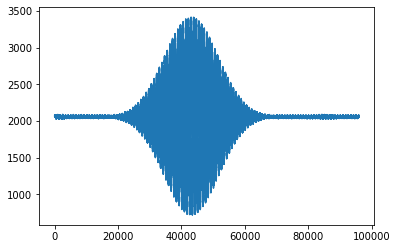

In [94]:
plt.plot(wav1)

In [357]:
#########################################

In [358]:
admin = TepAdmin()  ### decalring a shortcut to send SCPY commands to the machine
inst = admin.open_instrument(slot_id=sid)  ### decalring a shortcut to send SCPY commands to the machine

inst.close_instrument()
admin.close_inst_admin()

# ml.quitter(sid)

0